# Decision Analysis - Project 3

## Installs and Imports

In [39]:
!pip install pytorch-ignite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 3.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from ignite.engine import Events
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

In [ ]:
torch.manual_seed_all(42)

## Functions, Models and Utilities

In [19]:
def plot_columns(df, figsize = (12, 8)):
    num_cols = len(df.columns)
    num_rows = (num_cols + 1) // 2
    fig, axes = plt.subplots(num_rows, 2, figsize=figsize)
    if num_rows == 1:
        axes = axes.reshape(1, -1)
    for i, column in enumerate(df.columns):
        ax = axes[i // 2, i % 2]
        df[column].plot(kind='hist', ax=ax, title=column)
        ax.set_title(f"Distribution for {column}")
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
    fig.suptitle("Data Distribution Plot")
    plt.tight_layout()
    plt.show()

In [36]:
def use_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_preds = model.predict(X_train)
    accuracy = round(accuracy_score(y_train, y_preds), 4)
    f1 = round(f1_score(y_train, y_preds), 4)
    y_preds_positive = model.predict_proba(X_train)[:, 1]
    auc = round(roc_auc_score(y_train, y_preds_positive), 4)

    y_preds = model.predict(X_test)
    accuracy_test = round(accuracy_score(y_test, y_preds), 4)
    f1_test = round(f1_score(y_test, y_preds), 4)
    y_preds_positive = model.predict_proba(X_test)[:, 1]
    auc_test = round(roc_auc_score(y_test, y_preds_positive), 4)
    return model, accuracy, f1, auc, accuracy_test, f1_test, auc_test

In [ ]:
def morbius_transform(input_row):
    result = list(input_row)
    for i in range(len(input_row)):
        for j in range(i+1, len(input_row)):
            result.append(min(input_row[i], input_row[j]))
    return result

In [ ]:
class CriteriaLayer(nn.Linear):
    def __init__(self, num_in_features:int, include_bias:bool=False, min_weight:float=1e-8):
        super().__init__(num_in_features, 1, include_bias)
        self.is_bias = include_bias
        self.min_w = min_weight
        if include_bias:
            nn.init.uniform_(self.bias, self.min_w ,1.0)
        else:
            self.bias = None

    def reset_parameters(self):
        nn.init.uniform_(self.weight, 0.1, 1.0)

    def forward(self, input:torch.Tensor)->torch.Tensor:
        with torch.no_grad():
            self.weight.data[self.weight.data<0]=self.min_w
        weights = self.weight
        return F.linear(input, weights, self.bias)

In [ ]:
class InteractionLayer(nn.Linear):
    def __init__(self, num_in_features:int, criterion_layer:CriteriaLayer):
        num_interactions = ((num_in_features-1)*num_in_features)//2
        super().__init__(num_interactions, 1, False)
        self.in_features = num_in_features
        self.criterion_layer = criterion_layer
        self.num_interactions = num_interactions

    def reset_parameters(self):
        nn.init.normal_(self.weight, 0.0, 0.1)

    def forward(self, input:torch.Tensor)->torch.Tensor:
        with torch.no_grad():
            w_i=0
            w = self.criterion_layer.w()
            for i in range(self.in_features):
                for j in range(i+1,self.in_features):
                    self.weight.data[:,w_i] =  torch.max(self.weight.data[:,w_i], -w[:,i])
                    self.weight.data[:,w_i] =  torch.max(self.weight.data[:,w_i], -w[:,j])
                    w_i+=1
        weights = self.weight
        return F.linear(input, weights, None)

In [ ]:
class ThresholdLayer(nn.Module):
    """A threshold layer that subtracts a threshold from the input tensor.
    Alternatives from class 1 should have utility greater than the threshold.
    Alternatives from class 0 should have utility less than the threshold.

    """

    def __init__(self, threshold: float = None, requires_grad: bool = True):
        """Initialize the threshold layer.

        Args:
            threshold (float, optional): The threshold value. Defaults to None.
                If None, the threshold is initialized randomly.
            requires_grad (bool, optional): Whether the threshold should be trainable.
                Defaults to True.
        """
        super().__init__()
        if threshold is None:
            self.threshold = nn.Parameter(
                torch.FloatTensor(1).uniform_(0.1, 0.9), requires_grad=requires_grad
            )
        else:
            self.threshold = nn.Parameter(
                torch.FloatTensor([threshold]), requires_grad=requires_grad
            )

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """Forward pass of the threshold layer.

        Args:
            x (torch.FloatTensor): Input tensor.

        Returns:
            torch.FloatTensor: Output tensor.
        """
        return x - self.threshold

In [ ]:
class ChoquetIntegralConstrained(nn.Module):
    """Choquet Integral model with constraints on the weights.
    """
    def __init__(self, num_criteria:int):
        """Constructor for ChoquetIntegralConstrained

        Args:
            num_criteria (int): Number of criteria.
        """
        super().__init__()
        self.num_criteria = num_criteria
        self.criteria_layer = LinearGreaterThanZero(num_criteria)
        self.interaction_layer = LinearInteraction(num_criteria,self.criteria_layer)
        self.threshold_layer = ThresholdLayer()

    def forward(self, input:torch.Tensor)->torch.Tensor:
        """Forward pass of the model.

        Args:
            input (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """        """"""
        if len(input.shape)==3:
            input = input[:,0,:]

        # Calculate the criteria part of integral
        x_wi = self.criteria_layer(input[:,:self.num_criteria])
        # Calculate the interaction part of integral
        x_wij = self.interaction_layer(input[:,self.num_criteria:])
        # Normalize scores
        weight_sum = self.criteria_layer.w().sum()+self.interaction_layer.w().sum()
        score =  (x_wi+x_wij)/(weight_sum)
        return self.threshold_layer(score)

In [ ]:
model = ChoquetIntegralConstrained(num_criteria)
best_acc, best_auc,stats_train, stats_test, = Train(model, train_dataloader, test_dataloader, PATH, lr=0.01, epoch_nr=50)

In [ ]:
weights = model.criteria_layer.w().detach().numpy()[0]
interaction_weights = model.interaction_layer.w().detach().numpy()[0]
s = weights.sum()+interaction_weights.sum()
weights = weights/s
interaction_weights = interaction_weights/s

interactions = np.zeros((num_criteria,num_criteria))
weight_id =0
for i in range(num_criteria):
    for j in range(i+1,num_criteria):

        interactions[i,j] = interactions[j,i] = interaction_weights[weight_id]
        weight_id+=1

In [ ]:
print('Criteria weights:')
print(weights)
print()
print('Criteria interctions:')
print(interactions)

In [ ]:
shapley = weights + interactions.sum(0)/2
print('Importance of criterina (Shapley value):')
print(shapley)

In [ ]:
class ANN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x

class Compatible_Torch_Model():
    def __init__(self, model, optimizer, criterion, num_epochs):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.num_epochs = num_epochs

    def fit(self, X_train, y_train):
        print("Fitting Neural Network Model")
        self.model.train()
        train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        trainer = create_supervised_trainer(self.model, self.optimizer, self.criterion)
        evaluator = create_supervised_evaluator(self.model, metrics={'accuracy': Accuracy(), 'loss': Loss(self.criterion)})
        history = {'epoch': [], 'accuracy': [], 'loss': []}
        trainer.run(train_loader, max_epochs=self.num_epochs)

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history['epoch'], history['loss'], label='Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(history['epoch'], history['accuracy'], label='Training Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Training Accuracy')
        plt.legend()
        plt.tight_layout()
        plt.show()

        @trainer.on(Events.EPOCH_COMPLETED)
        def log_training_results(trainer):
            evaluator.run(train_loader)
            metrics = evaluator.state.metrics
            print(f"Training Results - Epoch: {trainer.state.epoch}  Avg accuracy: {metrics['accuracy']:.4f} Avg loss: {metrics['loss']:.4f}")
            history['epoch'].append(trainer.state.epoch)
            history['accuracy'].append(metrics['accuracy'])
            history['loss'].append(metrics['loss'])

    def predict(self, X):
        self.model.eval()
        predictions = []
        for temp_X in X:
            X_input = torch.tensor(temp_X).float()
            with torch.no_grad():
                output = self.model(X_input.unsqueeze(0))
            output = 1 if output > 0.5 else 0
            predictions.append(output)
        return np.array(predictions)

    def predict_proba(self, X):
        self.model.eval()
        predictions = []
        for temp_X in X:
            X_input = torch.tensor(temp_X).float()
            with torch.no_grad():
                output = self.model(X_input.unsqueeze(0))
            predictions.append([1-output, output])
        return np.array(predictions)

## Data

In [35]:
data = pd.read_csv("/content/mammographic.csv")
data = (data - data.min()) / (data.max() - data.min())
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
data

,BI-RADS,Age,Shape,Margin,Density,Severity
0,0.072727,0.525641,0.000000,0.00,0.666667,0.0
1,0.072727,0.333333,0.333333,0.00,0.666667,0.0
2,0.090909,0.474359,1.000000,1.00,0.666667,0.0
3,0.072727,0.076923,0.333333,0.00,0.666667,0.0
4,0.072727,0.358974,0.000000,0.00,0.666667,0.0
...,...,...,...,...,...,...
825,0.072727,0.615385,0.000000,0.00,0.666667,0.0
826,0.072727,0.038462,0.333333,0.00,0.666667,0.0
827,0.090909,0.833333,1.000000,0.75,0.666667,1.0
828,0.090909,0.628205,1.000000,1.00,0.666667,1.0


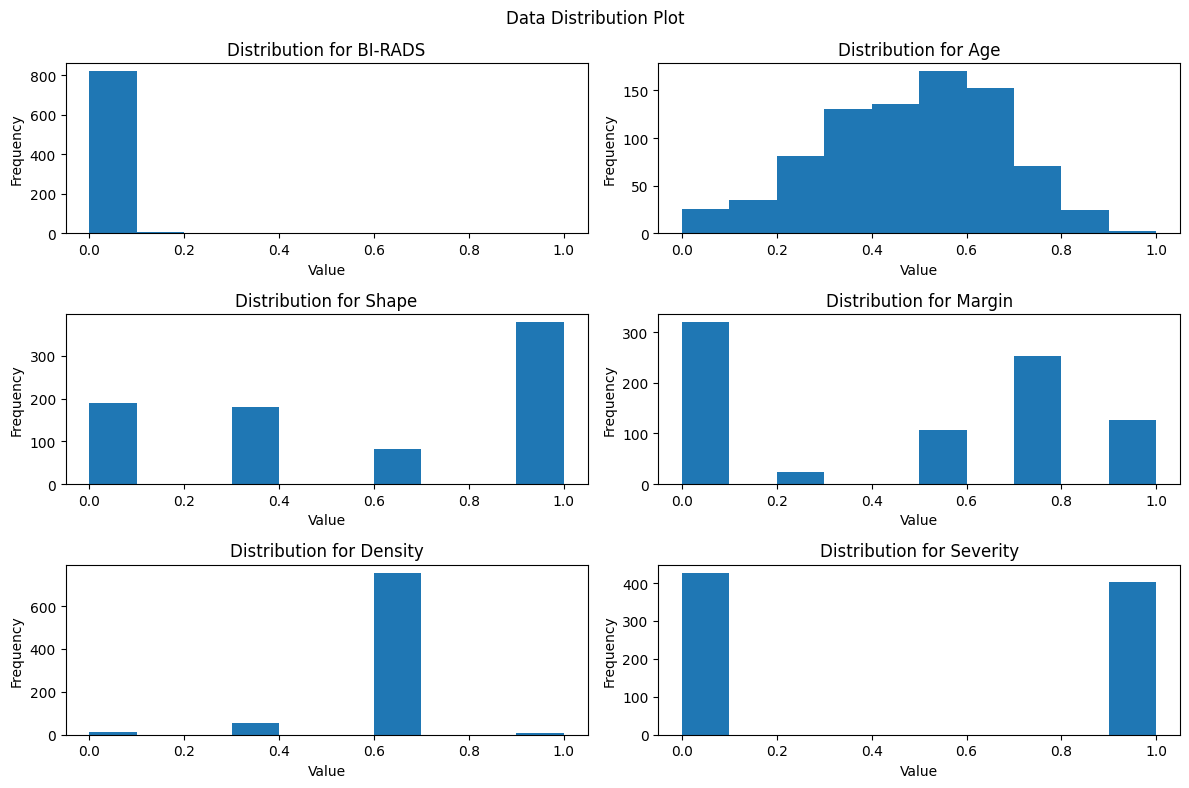

In [20]:
plot_columns(data)

In [ ]:
X = data.drop(columns = ["Severity"])
y = data["Severity"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)